# Pump-probe simple analysis example

This is a simple analysis example on how to:

    -load data and corrections for the Alvra 4.5M Jungfrau
    -correct Jungfrau images
    -do some basic analysis and plotting
    -It can be used to loop through files and plot the XAS transient as a function of Energy *OR* Delay

First, you import modules for Numpy (matrix manipulation), H5Py (HDF5 files), matplotlib (plotting) and jungfrau_utils (Jungfrau corrections)

In [4]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os

In [5]:
DIR = "/sf/alvra/data/p17589/raw/scan_data/timescan_7124eV_20uJ_5/"
#DIR = "/sf/alvra/data/p17589/raw/"

!ls -lah -t /sf/alvra/data/p17589/raw/scan_data/timescan_7124eV_20uJ_5/
#!ls -lah -t /sf/alvra/data/p17589/raw/

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 216G
drwxrwsr-x. 17 17589 p17589 4.0K Oct 29 05:29 ..
drwxrwsr-x.  2 17589 p17589 4.0K Oct 28 23:59 .
-rw-r--r--.  1 17589 p17589 2.1G Oct 28 23:59 timescan_7124eV_20uJ_5_step0010.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 28 23:56 timescan_7124eV_20uJ_5_step0010.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 28 23:55 timescan_7124eV_20uJ_5_step0009.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 28 23:52 timescan_7124eV_20uJ_5_step0009.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 28 23:48 timescan_7124eV_20uJ_5_step0008.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 28 23:45 timescan_7124eV_20uJ_5_step0008.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 28 23:45 timescan_7124eV_20uJ_5_step0007.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 28 23:42 timescan_7124eV_20uJ_5_step0007.JF02T09V01.h5
-rw-r--r--.  1 17589 p17589 2.1G Oct 28 23:41 timescan_7124eV_20uJ_5_step0006.BSREAD.h5
-rw-r--r--.  1 17589 p17589  18G Oct 28 23:38 timescan_7124eV_20uJ_5_step0006.JF02T0

# JF DATA ANALYSIS
Run the following cells to analyse the JF data.
If you want to access the BS data only, open the other notebook (BS_analysis)

In [6]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

#pede_file = "/sf/alvra/data/res/p16581/pedestal_20180307_2303_res.h5"
pede_file = "/sf/alvra/data/p17589/res/JF_pedestals/pedestal_20181028_1746.JF02T09V01.res.h5"
gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V01/gains.h5"

with h5py.File(gain_file, "r") as file: 
    G = file["gains"][:]
    
with h5py.File(pede_file, "r") as file: 
    P = file["gains"][:]
    mask = file["pixel_mask"][:]
    
print("Dimensions of G: ", G.shape)

Dimensions of G:  (4, 512, 9216)


In [7]:
fileName = "timescan_7124eV_20uJ_5_step0000.JF02T09V01.h5"

jf_file = h5py.File(DIR + fileName)
print(list(jf_file["data/JF02T09V01"].keys()))

images = jf_file["data/JF02T09V01/data"]
pulse_ids = jf_file["data/JF02T09V01/pulse_id"]

['daq_rec', 'daq_recs', 'data', 'frame', 'framenum_diff', 'framenums', 'is_good_frame', 'missing_packets_1', 'missing_packets_2', 'module_number', 'pulse_id', 'pulse_id_diff', 'pulse_ids']


In [8]:
print(jf_file)

<HDF5 file "timescan_7124eV_20uJ_5_step0000.JF02T09V01.h5" (mode r)>


<IPython.core.display.Javascript object>


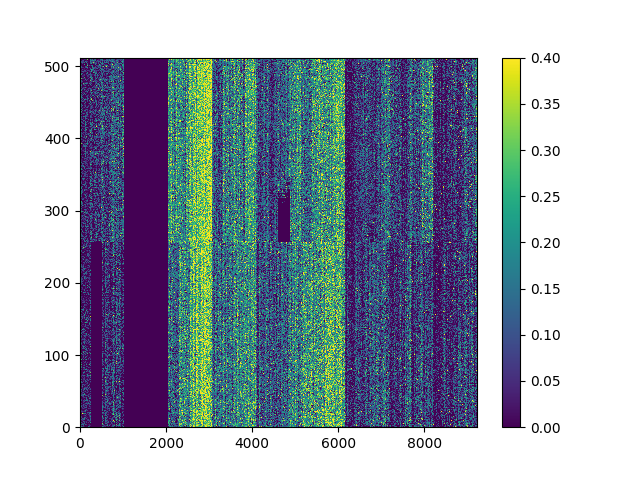

In [9]:
# First we load the first images to check if everything is fine with the pedestal & gain files (check highgain True or False)
# We can see also how the ROIs look like (will be useful later)

nframes = 10

#nframes=images.shape(0)

total = 0
threshold = 2
#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
roi = [[0, images.shape[1]], [0, images.shape[2]]]

for i in range(nframes):
    image = images[i][:]
    total += ju.apply_gain_pede(image, G=G, P=P, pixel_mask=mask, highgain=False)[roi[0][0]:roi[0][1], roi[1][0]:roi[1][1]]

total /= nframes


plt.figure()
plt.imshow(total, origin="lower", extent = [roi[1][0],roi[1][-1],roi[0][0],roi[0][-1]], aspect='auto', vmin=0, vmax=0.4)
plt.colorbar()
plt.show()

In [10]:
#This is to define a couple of functions that will be used later.

def rebin_sum(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).sum(axis=1)

def rebin_mean(a):
    if a.size%bin_ != 0:
        a = a[0:a.size//bin_ * bin_]

    return a.reshape((-1, bin_)).mean(axis=1)

# Convert energy to a number of photons counting values falling within a particular range.
# This will always return integer photon counts.
def convert_to_photon_num_range(image):
    return np.ceil(np.divide(image - photon_range[0], np.mean(photon_range)))

# Convert energy to a number of photons using the central energy of a single photon.
# This can return fractional number of photons.`
def convert_to_photon_num_mean(image):
    return image / np.mean(photon_range)

In [11]:
print(images.shape[0])

2000


In [12]:
#pulse_ids[0:10] % 4 == 0  # False = laser off -- this is for RepRate 25 (laser)
pulse_ids[0:10] % 20 == 0  # False = laser off -- this is for RepRate 5 (laser)

array([[ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False]])

In [13]:
#laser_on_off = pulse_ids[:] % 4 == 0 #-- this is for RepRate 25 (laser)
laser_on_off = pulse_ids[:] % 20 == 0 #-- this is for RepRate 10 (laser)

### The next cells are for checking individual files or a series of identical ones to be summed up. For looping over files of a scan, scroll below

In [14]:
######Time to loop over images. Signal is well localized, so we can set up a ROI. 
######Then we loop over images and fill two variables containing the laser on / off spectra.

### Run this to analyse ONLY ONE FILE

files = ["timescan_7124eV_20uJ_5_step0003"]


# Ka emission 
roi1 = [[225, 325], [6950, 7075]] # both crystals overlapped

#Kb emission
roi2 = [[225, 325], [8250, 8380]] # both crystals overlapped

spectra_on_roi1 = 0
spectra_off_roi1 = 0
spectra_on_roi2 = 0
spectra_off_roi2 = 0

n_spectra_on = 0
n_spectra_off = 0

threshold = 2
photon_range = (1, 3)

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

P_r_roi2 = P[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
G_r_roi2 = G[:, roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
mask_r_roi2 = mask[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]


for f in files:
    jf_file = h5py.File(DIR + f + ".JF02T09V01.h5", "r")
    print("Processing file %s" % (jf_file))
  #   images = jf_file["jungfrau/data"]
    pulse_ids = jf_file["data/JF02T09V01/pulse_id"]
    laser_on_off = pulse_ids[:] % 20 == 0
    #nframes = 10
    nframes = pulse_ids.size
    
    for i in range(nframes):
        image = jf_file["data/JF02T09V01/data"][i,:,:]

        image_roi1 = image[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi1 = ju.apply_gain_pede(image_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_roi1[image_roi1 < threshold] = 0
        image_roi1 = convert_to_photon_num_range(image_roi1)
        
        image_roi2 = image[roi2[0][0]:roi2[0][1], roi2[1][0]:roi2[1][1]]
        image_roi2 = ju.apply_gain_pede(image_roi2, G=G_r_roi2, P=P_r_roi2, pixel_mask=mask_r_roi2, highgain=False)
        image_roi2[image_roi2 < threshold] = 0
        image_roi2 = convert_to_photon_num_range(image_roi2)
        
        if laser_on_off[i]:
            spectra_on_roi1 += image_roi1.sum(axis=0)
            spectra_on_roi2 += image_roi2.sum(axis=0)
            n_spectra_on += 1

        else:
            spectra_off_roi1 += image_roi1.sum(axis=0)
            spectra_off_roi2 += image_roi2.sum(axis=0)
            
            n_spectra_off += 1

print(n_spectra_off, n_spectra_on)
print ("Job done!")

Processing file <HDF5 file "timescan_7124eV_20uJ_5_step0003.JF02T09V01.h5" (mode r)>
1000 1000
Job done!


In [34]:
print (Izero_on_tot)

[25455350.]


<IPython.core.display.Javascript object>


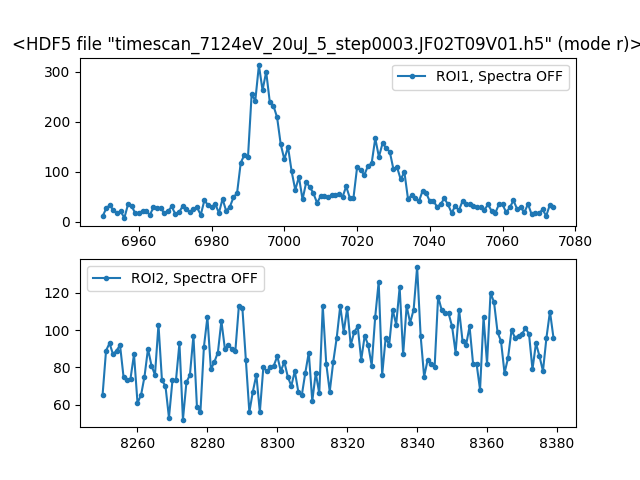

In [15]:
# Let's check if everything worked out fine, plotting one spectrum for instance the spectra with laser OFF.
# This is for ROI1

x_axis = np.arange(roi1[1][0], roi1[1][1])
plt.figure()

plt.subplot(211)
plt.plot(x_axis,spectra_off_roi1, label="ROI1, Spectra OFF", marker='.')
plt.legend(loc="best")
plt.title(jf_file)
x_axis = np.arange(roi2[1][0], roi2[1][1])
plt.subplot(212)
plt.plot(x_axis,spectra_off_roi2,label="ROI2, Spectra OFF",marker='.')
plt.legend(loc="best")

In [32]:
print (Izero_off_tot, Izero_on_tot)

[24104855.] [24104855.]


<IPython.core.display.Javascript object>


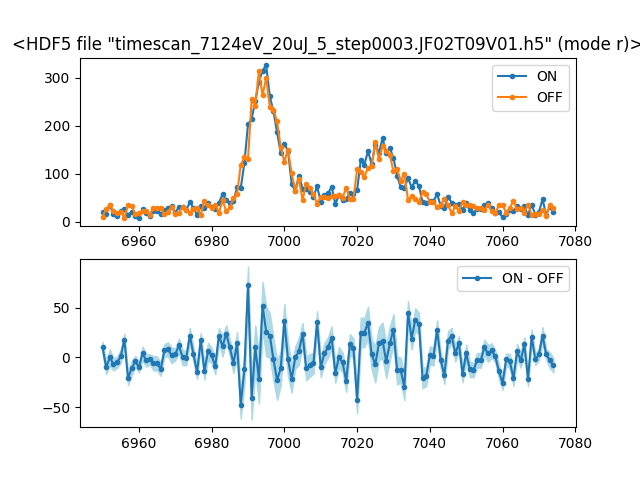

In [16]:
# # # This is for plotting laser on-off spectra from Roi1 to look for pump-probe

spectra_on = spectra_on_roi1.copy()
spectra_off = spectra_off_roi1.copy()

x_axis = np.arange(roi1[1][0], roi1[1][1])

bin_ = 1
spectra_on_rebin1 = rebin_sum(spectra_on)
spectra_off_rebin1 = rebin_sum(spectra_off)
x_axis_rebin1 = rebin_mean(x_axis)

spectra_on_err1=np.sqrt(spectra_on_rebin1)
spectra_off_err1=np.sqrt(spectra_off_rebin1)

plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1,spectra_on_rebin1, label="ON",marker='.')
plt.plot(x_axis_rebin1,spectra_off_rebin1, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)

plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

<IPython.core.display.Javascript object>


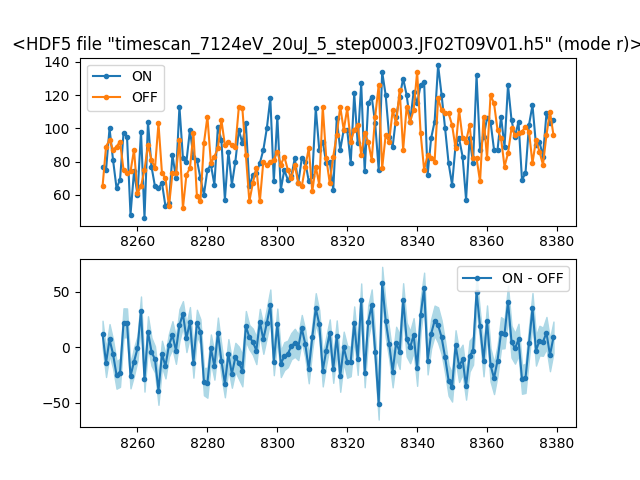

In [17]:
# # # This is for plotting laser on-off spectra from Roi2 to look for pump-probe

spectra_on = spectra_on_roi2.copy()
spectra_off = spectra_off_roi2.copy()
x_axis = np.arange(roi2[1][0], roi2[1][1])

bin_ = 1
spectra_on_rebin2 = rebin_sum(spectra_on)
spectra_off_rebin2 = rebin_sum(spectra_off)
x_axis_rebin2 = rebin_mean(x_axis)

spectra_on_err2=np.sqrt(spectra_on_rebin2)
spectra_off_err2=np.sqrt(spectra_off_rebin2)
plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin2,spectra_on_rebin2, label="ON",marker='.')
plt.plot(x_axis_rebin2,spectra_off_rebin2, label="OFF",marker='.')
plt.legend(loc="best")
plt.title(jf_file)

low_err= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)

plt.subplot(212)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
plt.legend(loc="best")
plt.fill_between(x_axis_rebin2, low_err, high_err, color='lightblue')
plt.show()

### The next cell is for looping over several files of a scan. 

In [18]:
### this is now to loop over SEVERAL FILES

listfile = os.listdir(DIR)
number_files = int(len(listfile)/2)
#number_files = 2

print ("Start processing",number_files,"files")
fileName_root = 'timescan_7124eV_20uJ_5'

# Ka emission 
roi1 = [[225, 325], [6950, 7075]] # both crystals overlapped

spectra_on_roi1 = 0
spectra_off_roi1 = 0

n_spectra_on = 0
n_spectra_off = 0

threshold = 2
photon_range = (1, 3)

P_r_roi1 = P[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
G_r_roi1 = G[:, roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
mask_r_roi1 = mask[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]

XAS_trans = []
XAS_trans_x = []
Delay_x = []
Error_XAS = []
RIXS_transient = []
Error_transient = []
RIXS_unpumped = []
Error_unpumped = []

for j in range(number_files):
    spectra_on_roi1 = 0
    spectra_off_roi1 = 0
    n_spectra_on = 0
    n_spectra_off = 0
    
    if j < 10:
        fileName = fileName_root + "_step000" + str(j) + ".JF02T09V01.h5"
        fileName_bs = fileName_root + "_step000" + str(j) + ".BSREAD.h5"
    else:
        fileName = fileName_root + "_step00" + str(j) + ".JF02T09V01.h5"
        fileName_bs = fileName_root + "_step00" + str(j) + ".BSREAD.h5"
    jf_file = h5py.File(DIR + fileName, "r")
    bs_file = h5py.File(DIR + fileName_bs, 'r')
    
    Energy_eV = bs_file["data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"]
    Delay_mm = bs_file["data/SLAAR11-LMOT-M451:ENC_1_BS/data"]
    XAS_trans_x.append(Energy_eV[0])
    Delay_x.append(Delay_mm[0])
    
    print("step",j+1,"of",number_files,": Processing %s" % (fileName))
  #   images = jf_file["jungfrau/data"]
    pulse_ids = jf_file["data/JF02T09V01/pulse_id"]
    laser_on_off = pulse_ids[:] % 20 == 0
    #nframes = 10
    nframes = pulse_ids.size
    
    for i in range(nframes):
        image = jf_file["data/JF02T09V01/data"][i,:,:]
        image_roi1 = image[roi1[0][0]:roi1[0][1], roi1[1][0]:roi1[1][1]]
        image_roi1 = ju.apply_gain_pede(image_roi1, G=G_r_roi1, P=P_r_roi1, pixel_mask=mask_r_roi1, highgain=False)
        image_roi1[image_roi1 < threshold] = 0
        image_roi1 = convert_to_photon_num_range(image_roi1)
        
        if laser_on_off[i]:
            spectra_on_roi1 += image_roi1.sum(axis=0)
        
            n_spectra_on += 1

        else:
            spectra_off_roi1 += image_roi1.sum(axis=0)
            
            n_spectra_off += 1
            
    #print('Total images in the file are', nframes)
    
    spectra_on_trans = spectra_on_roi1.copy()
    spectra_on_trans_err = np.sqrt(spectra_on_trans)
    Trans_on = spectra_on_trans.sum()
    Trans_on_err = spectra_on_trans_err.sum()
    
    spectra_off_trans = spectra_off_roi1.copy()
    spectra_off_trans_err = np.sqrt(spectra_off_trans)
    Trans_off = spectra_off_trans.sum()
    Trans_off_err = spectra_off_trans_err.sum()
    
    difference = Trans_on - Trans_off
    spectra_diff = spectra_on_trans - spectra_off_trans
    
    print (n_spectra_on, n_spectra_off, difference)
        
    error_trans_RIXS = np.sqrt(spectra_on_trans_err**2 + spectra_off_trans_err**2)
    error_trans_XAS = np.sqrt(Trans_on_err**2 + Trans_off_err**2)
    
    XAS_trans.append(difference)
    Error_XAS.append(error_trans_XAS)
    RIXS_unpumped.append(spectra_off_trans)
    Error_unpumped.append(spectra_off_trans_err)
    RIXS_transient.append(spectra_diff)
    Error_transient.append(error_trans_RIXS)

XAS_trans_x = np.array(XAS_trans_x)
Delay_x = np.array(Delay_x)
XAS_trans = np.array(XAS_trans)
Error_XAS = np.array(Error_XAS)
RIXS_transient = np.array(RIXS_transient)
Error_transient = np.array(Error_transient)
RIXS_unpumped = np.array(RIXS_unpumped)
Error_unpumped = np.array(Error_unpumped)


print ("Job done!")

Start processing 11 files
<HDF5 file "timescan_7124eV_20uJ_5_step0000.BSREAD.h5" (mode r)>
step 1 of 11 : Processing timescan_7124eV_20uJ_5_step0000.JF02T09V01.h5
1000 1000 -207.0
<HDF5 file "timescan_7124eV_20uJ_5_step0001.BSREAD.h5" (mode r)>
step 2 of 11 : Processing timescan_7124eV_20uJ_5_step0001.JF02T09V01.h5
1000 1000 -419.0
<HDF5 file "timescan_7124eV_20uJ_5_step0002.BSREAD.h5" (mode r)>
step 3 of 11 : Processing timescan_7124eV_20uJ_5_step0002.JF02T09V01.h5
1000 1000 -37.0
<HDF5 file "timescan_7124eV_20uJ_5_step0003.BSREAD.h5" (mode r)>
step 4 of 11 : Processing timescan_7124eV_20uJ_5_step0003.JF02T09V01.h5
1000 1000 289.0
<HDF5 file "timescan_7124eV_20uJ_5_step0004.BSREAD.h5" (mode r)>
step 5 of 11 : Processing timescan_7124eV_20uJ_5_step0004.JF02T09V01.h5
1000 1000 164.0
<HDF5 file "timescan_7124eV_20uJ_5_step0005.BSREAD.h5" (mode r)>
step 6 of 11 : Processing timescan_7124eV_20uJ_5_step0005.JF02T09V01.h5
1000 1000 2044.0
<HDF5 file "timescan_7124eV_20uJ_5_step0006.BSREAD.h5

<IPython.core.display.Javascript object>


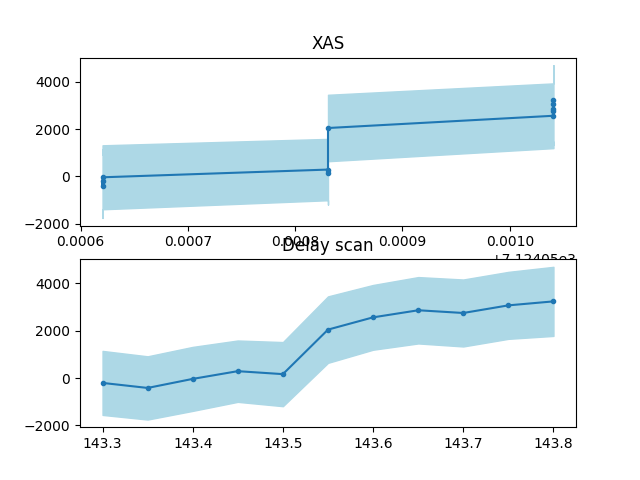

In [19]:
error_high = XAS_trans + Error_XAS
error_low = XAS_trans - Error_XAS

plt.figure()

plt.subplot(211)
plt.title("XAS")
plt.plot(XAS_trans_x, XAS_trans,label="Energy scan",marker='.') #This plot meaningful if it is a monoscan
plt.fill_between(np.squeeze(XAS_trans_x), error_low, error_high, color='lightblue')
plt.subplot(212)
plt.title("Delay scan")
plt.plot(Delay_x, XAS_trans,label="Delay scan",marker='.') #This plot meaningful if it is a timescan
plt.fill_between(np.squeeze(Delay_x), error_low, error_high, color='lightblue')


<IPython.core.display.Javascript object>


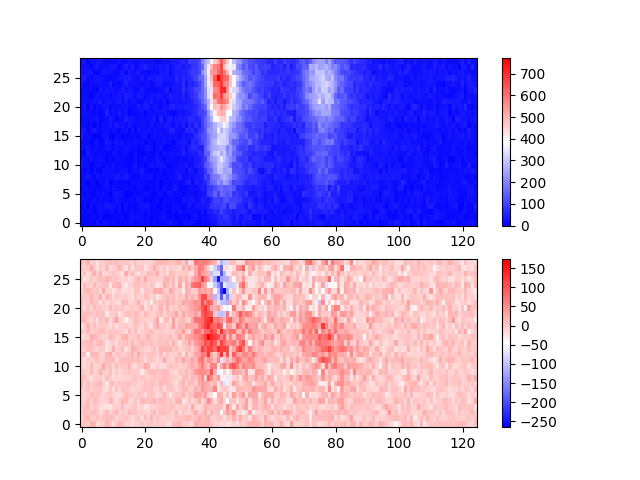

In [57]:
extent = [roi[1][0],roi[1][-1],roi[0][0],roi[0][-1]]


plt.figure()
plt.subplot(211)
plt.imshow(RIXS_unpumped, aspect = 'auto', cmap = "bwr", origin ="lower")
plt.colorbar()
plt.show()

plt.subplot(212)
plt.imshow(RIXS_transient, aspect = 'auto', cmap = "bwr", origin ="lower")#, vmin=-250, vmax=250)
plt.colorbar()
plt.show()
#fig.savefig('RIXS_unpumped')

In [15]:
#### This is to save data ####

savedir = "/das/work/p17/p17589/DataAnalysis/"
#savedir = "/das/work/p17/p17569/"

#h5f = h5py.File(savedir + 'test.h5','w') 
h5f = h5py.File(savedir + 'timeScan_4.h5','w')     
#h5f = h5py.File(savedir + 'RIXS_144.h5','w')

h5f.create_dataset('Delay_mm_BS', data = Delay_x)
h5f.create_dataset('Energy_BS', data = XAS_trans_x)
h5f.create_dataset('XAS_transient', data = XAS_trans)
h5f.create_dataset('Err_XAS_transient', data = Error_XAS)
h5f.create_dataset('RIXS_unpumped', data = RIXS_unpumped)
h5f.create_dataset('Err_RIXS_unpumped', data = Error_unpumped)
h5f.create_dataset('RIXS_transient', data = RIXS_transient)
h5f.create_dataset('Err_RIXS_transient', data = Error_transient)

h5f.close()

In [ ]:
XAS_trans_x_3ps = XAS_trans_x.copy()
XAS_trans_3ps = XAS_trans.copy()

<IPython.core.display.Javascript object>


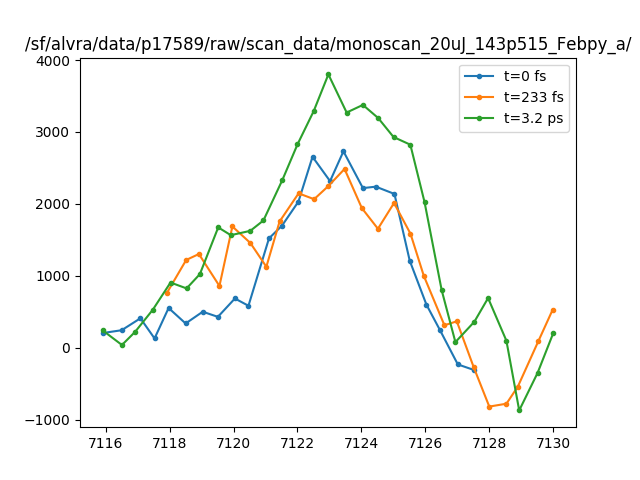

Text(0.5,1,'/sf/alvra/data/p17589/raw/scan_data/monoscan_20uJ_143p515_Febpy_a/')

In [199]:
plt.figure()
plt.plot(XAS_trans_x_0fs, XAS_trans_0fs,label="t=0 fs", marker='.')
plt.plot(XAS_trans_x_233fs, XAS_trans_233fs,label="t=233 fs", marker='.')
plt.plot(XAS_trans_x_3ps, XAS_trans_3ps,label="t=3.2 ps", marker='.')
plt.legend(loc="best")
plt.title(DIR)

In [20]:
Delay_5 = Delay_x.copy()
XAS_trans_5 = XAS_trans.copy()

<IPython.core.display.Javascript object>


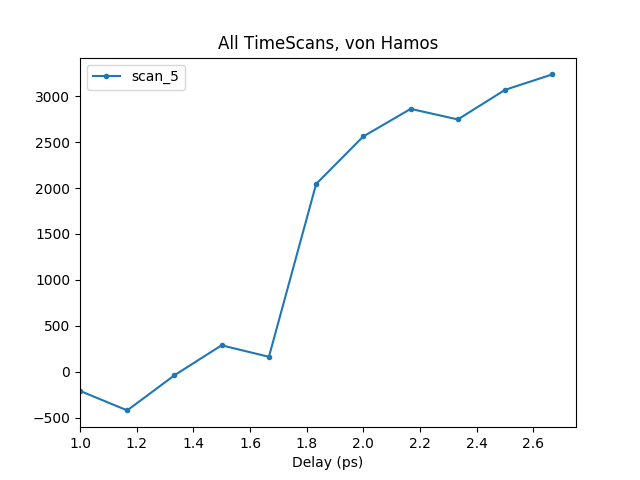

In [22]:
#Delay_ps_4 = (Delay_4 - 143)*3.333
Delay_ps_5 = (Delay_5 - 143)*3.333
#Delay_ps_6 = (Delay_6 - 143)*3.333
#Delay_ps_7 = (Delay_7 - 143)*3.333
#Delay_ps_8 = (Delay_8 - 143)*3.333

error_high = XAS_trans + Error_XAS
error_low = XAS_trans - Error_XAS

plt.figure()

#plt.plot(Delay_ps_4, XAS_trans_4,label="scan_4", marker='.')
plt.plot(Delay_ps_5, XAS_trans_5,label="scan_5", marker='.')
#plt.plot(Delay_ps_6, XAS_trans_6,label="scan_6", marker='.')
#plt.plot(Delay_ps_7, XAS_trans_7,label="scan_7", marker='.')
#plt.plot(Delay_ps_8, XAS_trans_8,label="scan_8", marker='.')
plt.xlabel("Delay (ps)")
plt.xlim([1, 2.75])

plt.legend(loc="best")
plt.title('All TimeScans, von Hamos')
plt.savefig('Timescans_all_PFY')

<IPython.core.display.Javascript object>


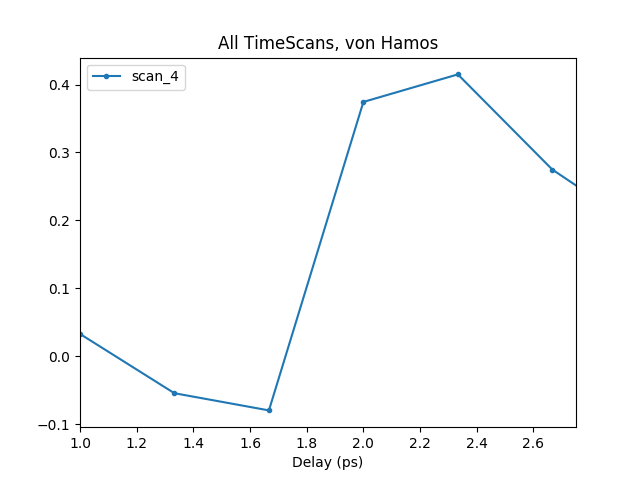

In [18]:
Delay_ps_4 = (Delay_4 - 143)*3.333
#Delay_ps_5 = (Delay_5 - 143)*3.333
#Delay_ps_6 = (Delay_6 - 143)*3.333
#Delay_ps_7 = (Delay_7 - 143)*3.333
#Delay_ps_8 = (Delay_8 - 143)*3.333

error_high = XAS_trans + Error_XAS
error_low = XAS_trans - Error_XAS

plt.figure()

plt.plot(Delay_ps_4, XAS_trans, label="scan_4", marker='.')
#plt.plot(Delay_ps_5, XAS_trans_5,label="scan_5", marker='.')
#plt.plot(Delay_ps_6, XAS_trans_6,label="scan_6", marker='.')
#plt.plot(Delay_ps_7, XAS_trans_7,label="scan_7", marker='.')
#plt.plot(Delay_ps_8, XAS_trans_8,label="scan_8", marker='.')
plt.xlabel("Delay (ps)")
plt.xlim([1, 2.75])

plt.legend(loc="best")
plt.title('All TimeScans, von Hamos')
plt.savefig('Timescans_all_PFY')

In [16]:
print (bs_file)

<HDF5 file "timescan_7124eV_20uJ_5_step0004.BSREAD.h5" (mode r)>
